### Extended and Unscented Kalman FilterDemo

<br>

- In this demo, I will walk through and compare some basic problems that an extended/unscented kalman filter can solve in the following procedure
    - Parameter Setup
    - Calculations & Logic
    - Analyzing Results
<br>
<br>

In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
os.chdir("..")

In [3]:
from trackingfilters.kalman import ExtKalmanFilter as ekf
from trackingfilters.kalman import UnscentedKalmanFilter as ukf

In [4]:
%load_ext autoreload
%autoreload 2

### Basic Trignometric Function (Sine)
- True state is that 
- Replicate some fake meausures

In [5]:
transition_func = lambda x: np.sin(x) + x
observation_func = lambda x: x

In [6]:
init_state_vec = np.array([0.1]).reshape(-1, 1)
init_state_cov_mat = np.array([15]).reshape(-1, 1)

measure_var = 1

measure_noise_mat = np.array([measure_var]).reshape(-1, 1)
process_noise_mat = np.array([0.025]).reshape(-1, 1)

num_measurements = 100
true_state = [0.55]
for num_measures in range(1, 100):
    true_state.append(transition_func(true_state[-1]))
true_state = np.array(true_state)
true_value = observation_func(true_state)
measurements = true_value + np.random.randn(num_measurements) * np.sqrt(measure_var)

In [7]:
sine_ekf = ekf(init_state_vec, init_state_cov_mat, process_noise_mat, measure_noise_mat, transition_func, observation_func)

In [8]:
sine_ukf = ukf(init_state_vec, init_state_cov_mat, process_noise_mat, measure_noise_mat, transition_func, observation_func)

In [9]:
sine_ekf.vec_update(measurements)

In [10]:
sine_ukf.vec_update(measurements)

In [11]:
ekf_vec, ekf_cov_mat, ekf_kalman_mat = sine_ekf.agg_result()

In [12]:
ukf_vec, ukf_cov_mat, ukf_kalman_mat = sine_ukf.agg_result()

### Performance
- We can see that UKF performs better than EKF (In fact it can detect convergence and its kalman gain stays at zero afterwards)
- UKF uses unscented transformation and yields optimal results when linearizing a non-linear problem
- EKF, in contrast does not yield optimal result

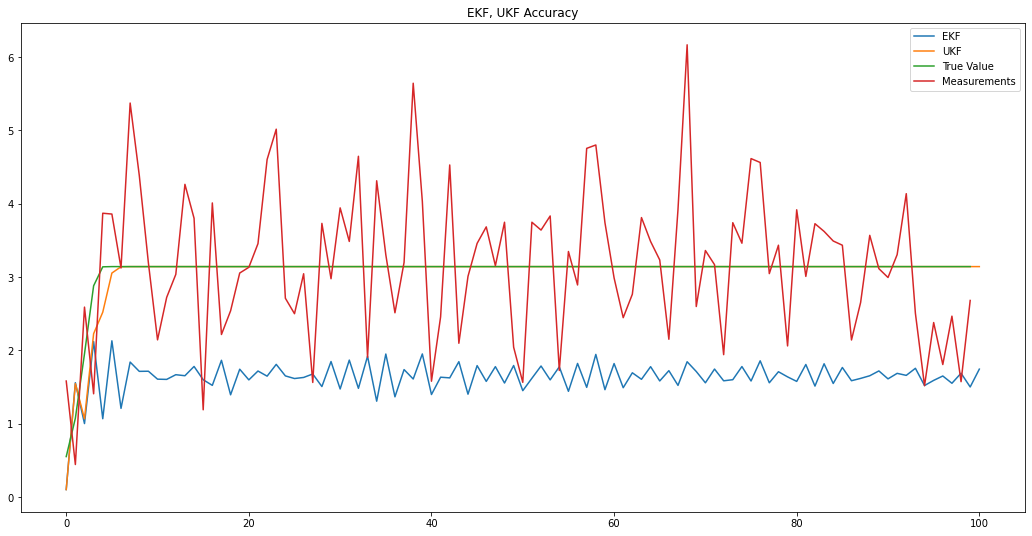

In [13]:
fig, ax = plt.subplots(figsize=(18,9));
ax.plot(ekf_vec.flatten(), label="EKF");
ax.plot(ukf_vec.flatten(), label="UKF");
ax.plot(true_value, label="True Value")
ax.plot(measurements, label="Measurements");
ax.set_title("EKF, UKF Accuracy");
plt.legend();
plt.show()

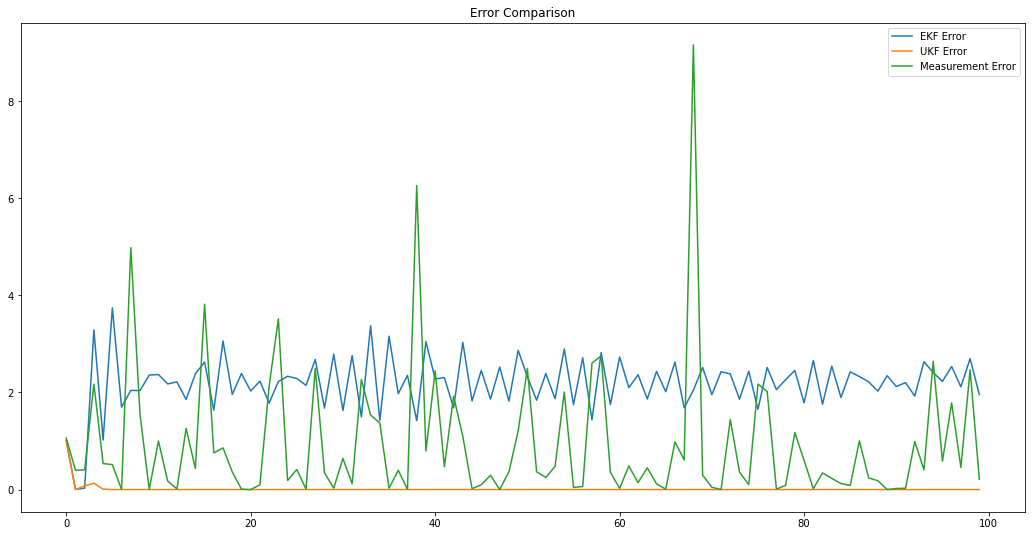

In [14]:
fig, ax = plt.subplots(figsize=(18,9));
ax.plot(np.power(ekf_vec.flatten()[1:] - true_value, 2), label="EKF Error");
ax.plot(np.power(ukf_vec.flatten()[1:] - true_value, 2), label="UKF Error");
ax.plot(np.power(measurements - true_value, 2), label="Measurement Error");
ax.set_title("Error Comparison");
plt.legend();
plt.show()

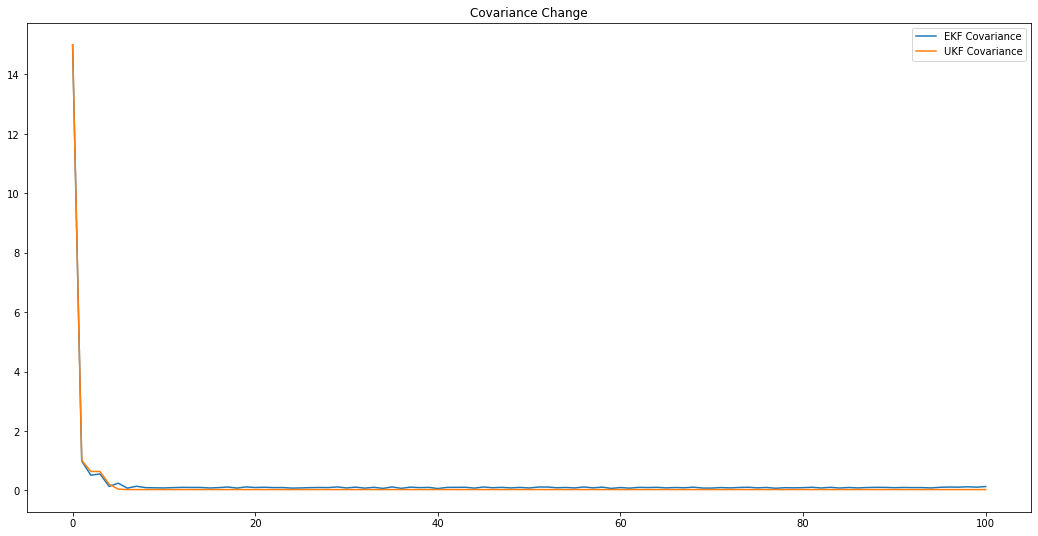

In [15]:
fig, ax = plt.subplots(figsize=(18,9));
ax.plot(ekf_cov_mat[:, 0, 0], label="EKF Covariance");
ax.plot(ukf_cov_mat[:, 0, 0], label="UKF Covariance");
ax.set_title("Covariance Change");
plt.legend();
plt.show()

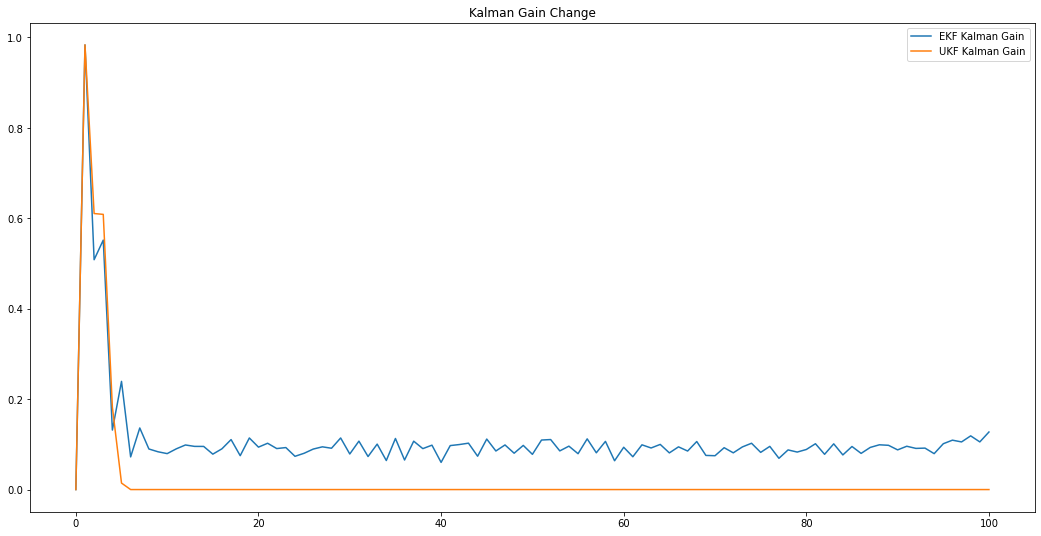

In [16]:
fig, ax = plt.subplots(figsize=(18,9));
ax.plot(ekf_kalman_mat[:, 0, 0], label="EKF Kalman Gain");
ax.plot(ukf_kalman_mat[:, 0, 0], label="UKF Kalman Gain");
ax.set_title("Kalman Gain Change");
plt.legend();
plt.show()

### Bug Moving away from a Sink
- A bug moves irregularly away from a sink
- We measure the angle, the distance and the velocity
- Notice that UKF's enhanced performance over EKF in the long run

In [536]:
def bug_movement(x):
    new_x = np.zeros(shape=x.shape)
    new_x[0] = x[0] + np.sin(x[1]) * x[2] # Distance from the Sink
    new_x[1] = (x[1] + x[2]) % (2 * np.pi) # Angle with the Sink
    new_x[2] = x[2] + 0.01 # Constant Acceleration
    return new_x

In [537]:
observation_func = lambda x: x

In [540]:
init_state_vec = np.array([0, 0, 0]).reshape(-1, 1)
init_state_cov_mat = np.diag([10, 10 ,10])

In [541]:
process_noise_mat = np.eye(3) * 0.25
measure_noise_mat = np.eye(3) * 0.25

In [542]:
num_measurements = 1000
true_state = [bug_movement(init_state_vec)]
for num_measures in range(1, num_measurements):
    true_state.append(bug_movement(true_state[-1]))
true_state = np.array(true_state)

In [543]:
true_distance = np.array([true_state[i][0] for i in range(len(true_state))]).flatten()
true_angle = np.array([true_state[i][1] for i in range(len(true_state))]).flatten()
true_velocity = np.array([true_state[i][2] for i in range(len(true_state))]).flatten()

In [544]:
measurement_distance = (true_distance + np.random.randn(num_measurements) * 2).reshape(-1, 1)
measurement_angle = (true_angle + np.random.randn(num_measurements) * 0.01).reshape(-1, 1)
measurement_velocity = (true_velocity + np.random.randn(num_measurements) * 0.5).reshape(-1, 1)

In [545]:
measurements = np.concatenate([measurement_distance, measurement_angle, measurement_velocity],axis=1)

In [546]:
bug_movement_ekf = ekf(init_state_vec, init_state_cov_mat, process_noise_mat, measure_noise_mat, bug_movement, observation_func)

In [547]:
bug_movement_ekf.vec_update(measurements)

In [548]:
ekf_state, ekf_cov, ekf_kalman = bug_movement_ekf.agg_result()

In [549]:
bug_movement_ukf = ukf(init_state_vec, init_state_cov_mat, process_noise_mat, measure_noise_mat, bug_movement, ukf_observation_func)

In [550]:
bug_movement_ukf.vec_update(measurements)

In [551]:
ukf_state, ukf_cov, ukf_kalman = bug_movement_ukf.agg_result()

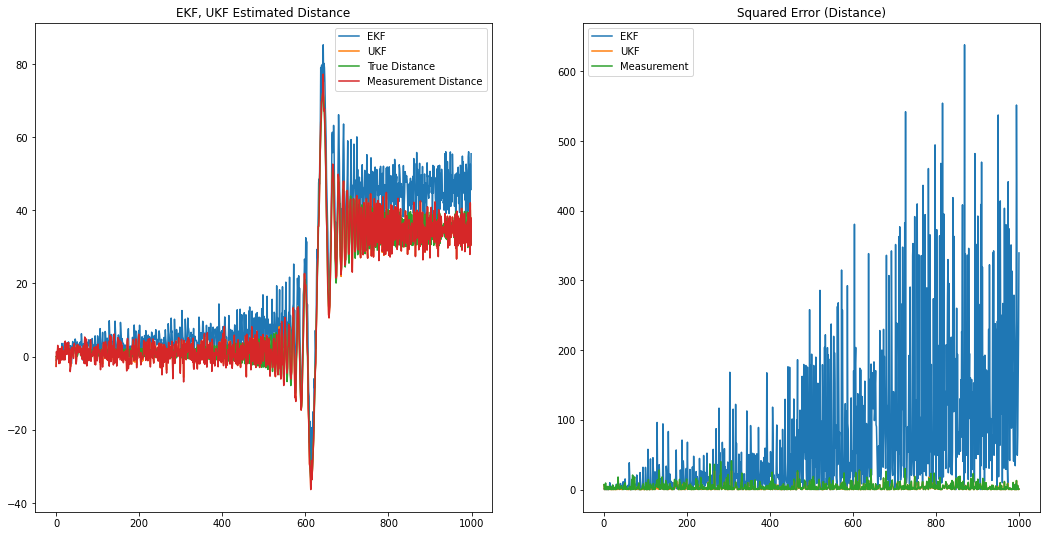

In [552]:
fig, ax = plt.subplots(figsize=(18,9), ncols=2);

ax[0].plot(ekf_state[1:, 0, 0], label="EKF");
ax[0].plot(ukf_state[1:, 0, 0], label="UKF");
ax[0].plot(true_distance, label="True Distance")
ax[0].plot(measurements[:, 0], label="Measurement Distance");
ax[0].set_title("EKF, UKF Estimated Distance");
ax[0].legend();
ax[1].plot(np.power(ekf_state[1:, 0, 0] - true_distance, 2), label="EKF");
ax[1].plot(np.power(ukf_state[1:, 0, 0] - true_distance, 2), label="UKF");
ax[1].plot(np.power(measurements[:, 0] - true_distance, 2), label="Measurement");
ax[1].set_title("Squared Error (Distance)");
ax[1].legend();
plt.show()

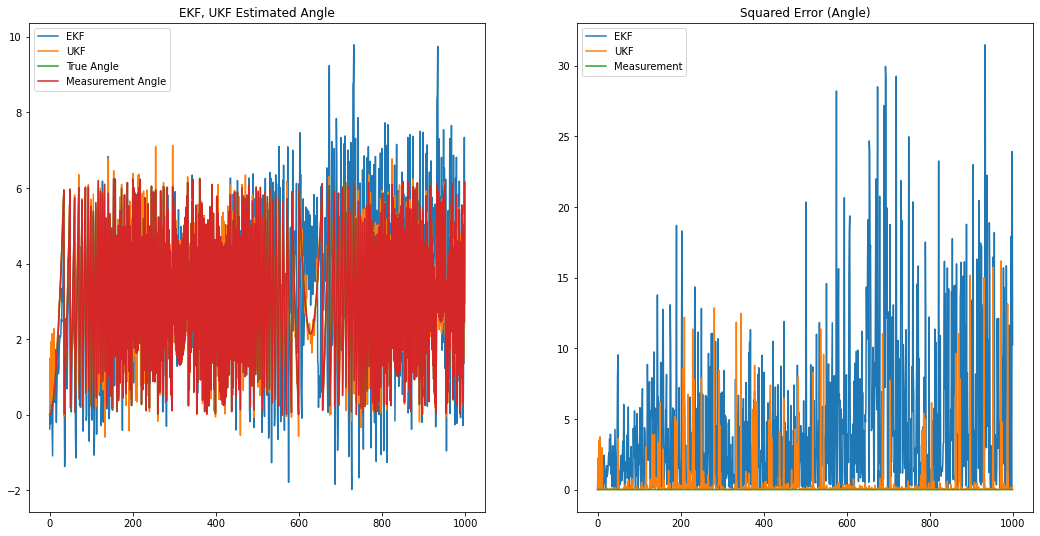

In [553]:
fig, ax = plt.subplots(figsize=(18,9), ncols=2);

ax[0].plot(ekf_state[1:, 1, 0], label="EKF");
ax[0].plot(ukf_state[1:, 1, 0], label="UKF");
ax[0].plot(true_angle, label="True Angle")
ax[0].plot(measurements[:, 1], label="Measurement Angle");
ax[0].set_title("EKF, UKF Estimated Angle");
ax[0].legend()
ax[1].plot(np.power(ekf_state[1:, 1, 0] - true_angle, 2), label="EKF");
ax[1].plot(np.power(ukf_state[1:, 1, 0] - true_angle, 2), label="UKF");
ax[1].plot(np.power(measurements[:, 1] - true_angle, 2), label="Measurement");
ax[1].set_title("Squared Error (Angle)");
ax[1].legend();
plt.show()

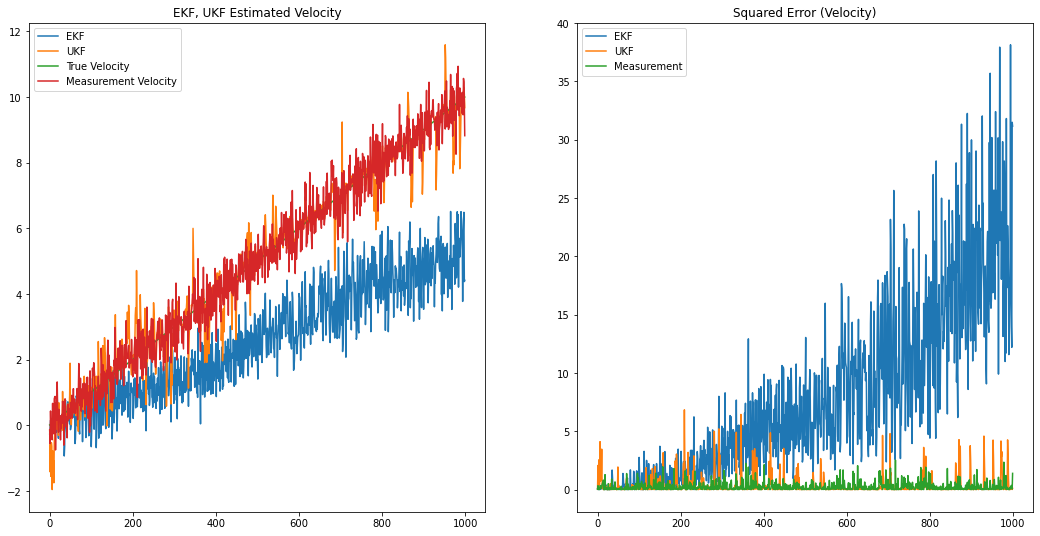

In [554]:
fig, ax = plt.subplots(figsize=(18,9), ncols=2);

ax[0].plot(ekf_state[1:, 2, 0], label="EKF");
ax[0].plot(ukf_state[1:, 2, 0], label="UKF");
ax[0].plot(true_velocity, label="True Velocity")
ax[0].plot(measurements[:, 2], label="Measurement Velocity");
ax[0].set_title("EKF, UKF Estimated Velocity");
ax[0].legend();

ax[1].plot(np.power(ekf_state[1:, 2, 0] - true_velocity, 2), label="EKF");
ax[1].plot(np.power(ukf_state[1:, 2, 0] - true_velocity, 2), label="UKF");
ax[1].plot(np.power(measurements[:, 2] - true_velocity, 2), label="Measurement");
ax[1].set_title("Squared Error (Velocity)");
ax[1].legend();
plt.show()